In [7]:
import torch
import torchvision.models
import hiddenlayer as hl

In [8]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

/home/students/s265780/.local/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/home/students/s265780/.local/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:267: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


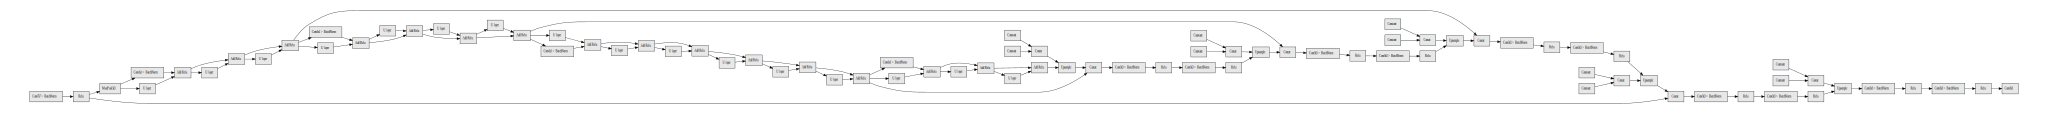

In [13]:
transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Add > Relu", "AddRelu", "Add Relu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
    hl.transforms.Fold("ConvBn > Relu > ConvBn > Relu > ConvBn", "Ulayer", "U layer"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]

# Display graph using the transforms above
hl.build_graph(model, torch.zeros([1, 3, 224, 224]), transforms=transforms)

In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import datetime, os

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def create_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

In [6]:
def train_model():
    model = create_model()
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    logdir = os.path.join("tblogs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])

train_model()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 32s 534us/sample - loss: 0.4967 - accuracy: 0.8224 - val_loss: 0.4261 - val_accuracy: 0.8456
Epoch 2/5
60000/60000 [==============================] - 32s 535us/sample - loss: 0.3819 - accuracy: 0.8608 - val_loss: 0.3755 - val_accuracy: 0.8657
Epoch 3/5
60000/60000 [==============================] - 32s 533us/sample - loss: 0.3494 - accuracy: 0.8730 - val_loss: 0.3621 - val_accuracy: 0.8703
Epoch 4/5
60000/60000 [==============================] - 30s 507us/sample - loss: 0.3285 - accuracy: 0.8802 - val_loss: 0.3519 - val_accuracy: 0.8783
Epoch 5/5
60000/60000 [==============================] - 30s 500us/sample - loss: 0.3107 - accuracy: 0.8855 - val_loss: 0.3352 - val_accuracy: 0.8791


In [9]:
%tensorboard --logdir tblogs

In [45]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir ./tblogs (started 0:00:00 ago; pid 3301)


In [19]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

--2021-01-25 10:03:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving mf1-bigdata.polito.it (mf1-bigdata.polito.it)... 192.168.129.51
Connecting to mf1-bigdata.polito.it (mf1-bigdata.polito.it)|192.168.129.51|:8000... connected.
Proxy request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  10.5MB/s    in 1.3s    

2021-01-25 10:03:05 (10.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [44]:
LOG_DIR = './tblogs'
port = 6006

get_ipython().system_raw(
    f'tensorboard --logdir {LOG_DIR} --host 0.0.0.0 --port {port} &'
)

In [46]:
get_ipython().system_raw(f'./ngrok http {port} &')

In [47]:
! curl -s http://localhost:4040/api/tunnels

<html>
<head>
<meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>
<title>Error 500 Server Error</title>
</head>
<body><h2>HTTP ERROR 500</h2>
<p>Problem accessing /api/tunnels. Reason:
<pre>    Server Error</pre></p><h3>Caused by:</h3><pre>javax.servlet.ServletException: Could not determine the proxy server for redirection
	at org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.findRedirectUrl(AmIpFilter.java:211)
	at org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.doFilter(AmIpFilter.java:145)
	at org.spark_project.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1767)
	at org.spark_project.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:583)
	at org.spark_project.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1180)
	at org.spark_project.jetty.servlet.ServletHandler.doScope(ServletHandler.java:513)
	at org.spark_project.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1112)
	at org.spark_

In [40]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(sys.stdin); print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

<_io.TextIOWrapper name='<stdin>' mode='r' encoding='UTF-8'>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/bigdatalab/lib/python3.7/json/__init__.py", line 296, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/opt/anaconda3/envs/bigdatalab/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/opt/anaconda3/envs/bigdatalab/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/opt/anaconda3/envs/bigdatalab/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
